# **Mount the Drive and change the working directory:**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/MSC Thesis

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/MSC Thesis


# Import Required Modules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn
from sklearn.feature_selection import mutual_info_regression

predictors = pd.read_csv('pred_inputs.csv')
predict_these = np.unique(predictors['INSTRUMENT'])

# Functions for preprocessing and Feature Generation

In [0]:
def from_csv(instrument):
    df = pd.read_csv('Data/' + instrument + '.csv')
    df['date'] = pd.to_datetime(df['date']).dt.date
    df.set_index('date',inplace=True)
    df = df.sort_values(by = 'date')
    df.columns = [instrument]
    return df
  
def preprocessing(commodity):
    #####################################################################################
    # This ensures chronological order (some time series are NOT in order)              #
    #####################################################################################
    
    prices_df = db.get_instrument_data(commodity)
    prices_df = prices_df.sort_values(by = 'date')
    prices_df.columns = [commodity]
    return prices_df
  
def get_predictors(commodity, predictors):
    ####################################################################
    # This returns the df containing the values of the commodity to be #
    # predicted as well as that of its predictors.                     #
    #                                                                  #
    # Args:                                                            #
    # 1) commodity: name of the commodity                              #
    # 2) predictors: the dataframe sent by Michael Button              #
    ####################################################################
    
    # get a list of all its predictors
    Pred = list(predictors.loc[predictors['INSTRUMENT'] == commodity]['INPUT'])
    Pred = [p for p in Pred if p != commodity]
    
    # Initialize the dataframe with the commodity we want to predict
    DF = from_csv( commodity )
    
    # Keep adding the predictors
    for predictor in Pred:
        temp_df = from_csv( predictor )
        DF = DF.join(temp_df)
    return DF
  
def price_to_returns(prices_df, diff):
    ###############################################################
    # This changes the price data to 5 day log difference.        #
    # If X has negative values, use the following scheme:         # 
    #          X := X - min(X) + 1                                #
    ###############################################################
    
    # forward fill
    prices_df.fillna(method='ffill', inplace = True)
    
    returns_df = prices_df.copy()
    for colname in prices_df.columns:
        temp = prices_df.loc[:,colname]
        
        if np.min(temp) <= 0:
            temp = temp - np.min(temp) + 1
        returns_df[colname] = np.log(temp) - np.log(temp.shift(diff))

    # drop rows with NaN
    returns_df.dropna(inplace = True)
    return returns_df
  
  
def feature_generation(metal, time_pred = [1,5,22]):
  metal = metal + '_lme_prices'
  Metal_DF = get_predictors(metal, predictors)
  # remove comex, since comex is not 
  Metal_DF = Metal_DF[[col for col in list(Metal_DF.columns) if 'comex' not in col]]
  
  # 1, 5, 22 days
  # log difference L
  LD = [price_to_returns(Metal_DF, t_pred) for t_pred in time_pred]

  # EWMA of L
  # EWMA = [L.ewm(span = horizon).mean() for horizon, L in zip(time_pred, LD)]
  EWMA = [LD[0].ewm(halflife = horizon).mean() for horizon in time_pred ]

  # EWMV of L
  # 1. calculate expanding window mean for the returns (1 day) 
  # 2. subtract rolling mean and take square
  EM = LD[0].expanding(2).mean() 
  EWMV = [((LD[0] - EM)**2).ewm(span = horizon).mean()**0.5 for horizon in time_pred ]
  
  # rename columns
  for horizon, ld, ewma, ewmv in zip(time_pred, LD, EWMA, EWMV):
    ld.columns = [col + '_LD_' + str(horizon) for col in ld.columns]
    ewma.columns = [col + '_EWMA_' + str(horizon) for col in ewma.columns]
    ewmv.columns = [col + '_EWMV_' + str(horizon) for col in ewmv.columns]
    
  # merge together 
  ALL_FEATURES = pd.concat([pd.concat(DFS, axis = 1, sort=True) for DFS in [LD, EWMA, EWMV]], axis = 1)
  ALL_FEATURES_columns = list(ALL_FEATURES.columns)
  ALL_FEATURES_columns.sort()
  ALL_FEATURES = ALL_FEATURES.loc[:,ALL_FEATURES_columns]
  ALL_FEATURES.dropna(inplace = True)
  
  return ALL_FEATURES



def feature_extraction(DF, column_name, lag):
  # This extracts the relevant predictors for the column_name
  # threshold is the % of predictors that we want to include
  # Mutual Information
  DF_metal = DF.loc[:,[column_name]]
  MI_table = np.zeros(DF.shape[1])
  for i in range(DF.shape[1]):
      MI = sklearn.feature_selection.mutual_info_regression(DF_metal, DF.iloc[:,i])
      MI_table[i] = MI
  
  tol = 1e-3
  MI_table_2 = MI_table[MI_table > tol]
  out, bins = pd.qcut(MI_table_2, [0.9, 1], retbins=True)
  selected_cols = list(MI_table > bins[-2])
  
  DF = DF.loc[:,selected_cols].shift(periods = lag)
  DF.columns = [col + '_lag' for col in DF.columns]
  DF = pd.concat([DF_metal, DF], axis = 1, sort = True).dropna()
  time_column = pd.DataFrame(index = DF.index, 
                             data = np.arange(DF.shape[0])*0.1 , 
                             columns = ['time'] )
  DF = pd.concat([DF, time_column], axis = 1)
  # add time column
  
  
  return(DF)


In [0]:
DF = feature_generation('al', time_pred = [1,5,22])
DF = feature_extraction(DF, 'al_lme_prices_LD_1',1)

# Import GPytorch

In [3]:
!pip install gpytorch
import torch
import gpytorch 

     |████████████████████████████████| 215kB 5.1MB/s 
  Created wheel for gpytorch: filename=gpytorch-0.3.5-py2.py3-none-any.whl size=349719 sha256=cea5b1cc91f00e2d7a6fc0a232a566e5072087087fb12c5af6dae3c7b2ddd830
  Stored in directory: /root/.cache/pip/wheels/d6/31/88/c43a94e0073a54056ac663366f2195de36535b38a81a378196
Successfully built gpytorch


# Get Gpytorch model ExactGPModel

In [0]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# First do Aluminium

In [0]:
Windows = [50, 100, 150]
Horizons = [1, 5, 22]
AL_Target_Variables = ['al_lme_prices_LD_1', 'al_lme_prices_LD_5', 'al_lme_prices_LD_22']
Kernels = [gpytorch.kernels.RBFKernel, gpytorch.kernels.MaternKernel]
trials = 100

In [0]:

def GET_STAT(metal, Windows, Horizons, Target_Variables, Kernels, trials):

  # metal is either 'al' or 'cu'
  
  I = len(Horizons)
  J = len(Kernels)
  K = len(Windows)
  
  MSE = np.zeros((I,J,K,trials))
  DIR = np.zeros((I,J,K,trials))
  BM = np.zeros((I,J,K,trials))

  for i,H_TV in enumerate(zip(Horizons, Target_Variables)):
    # horizon and target variable
    H = H_TV[0]
    TV = H_TV[1]
    
    DF = feature_generation(metal, time_pred = [1,5,22])
    DF = feature_extraction(DF, TV, H)
    
    
    # X is the predictors - all but the first column
    X = DF.iloc[:,1:]
    
    # Y is the target variable - just the first column
    Y = DF.iloc[:,[0]]
    
    ard_param = X.shape[1]

    for j,Kernel in enumerate(Kernels):
      for k,Window in enumerate(Windows):
        for t in range(trials):

          START = int(np.random.choice(np.arange(len(Y) - 200),1) )
          END = START + Window
          X_train = torch.tensor( X.iloc[START:END, :].values , dtype = torch.float32)
          X_test = torch.tensor( X.iloc[[END -1 + H], :].values , dtype = torch.float32)
          Y_train = torch.tensor( Y.iloc[START:END, :].values.T.squeeze() , dtype = torch.float32)
          Y_test = torch.tensor( Y.iloc[END -1 + H, :].values.T.squeeze() , dtype = torch.float32)

          likelihood = gpytorch.likelihoods.GaussianLikelihood()
          model = ExactGPModel(X_train, Y_train, likelihood, Kernel(ard_num_dims = ard_param))
          model.train()
          likelihood.train()

          # Use the adam optimizer
          optimizer = torch.optim.Adam([
              {'params': model.parameters()},  # Includes GaussianLikelihood parameters
          ], lr=0.1)

          # "Loss" for GPs - the marginal log likelihood
          mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
          training_iter = 100
          for l in range(training_iter):
              optimizer.zero_grad()
              output = model(X_train)
              loss = -mll(output, Y_train)
              loss.backward()
              optimizer.step()

          # Get into evaluation (predictive posterior) mode
          model.eval()
          likelihood.eval()

          # Make predictions by feeding model through likelihood
          with torch.no_grad(), gpytorch.settings.fast_pred_var():
              observed_pred = likelihood(model(X_test))

          MSE[i,j,k,t] = (observed_pred.mean - Y_test).numpy()**2
          DIR[i,j,k,t] = (torch.sign(observed_pred.mean) == torch.sign(Y_test)).numpy()
          BM[i,j,k,t] = Y_test.numpy()**2

        print(TV, ', Kernel = ', str(Kernel),', Window = ', Window)
        print('MSE = ', np.mean(MSE[i,j,k,:]), 
              ', RMSE = ', np.mean(MSE[i,j,k,:])**0.5, 
              ', DIR = ', np.mean(DIR[i,j,k,:]), 
              ', BENCHMARK = ', np.mean(BM[i,j,k,:]))
        print(' ')
        

In [0]:
GET_STAT('al',Windows, Horizons, AL_Target_Variables,Kernels, trials = 50)

al_lme_prices_LD_5 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.0019729890278808605 , RMSE =  0.04441834112031719 , DIR =  0.54 , BENCHMARK =  0.001313752518315141
 
al_lme_prices_LD_5 , Kernel =  <class 'gpytorch.kernels.matern_kernel.MaternKernel'> , Window =  100
MSE =  0.0011453146558780957 , RMSE =  0.03384249777835696 , DIR =  0.54 , BENCHMARK =  0.0005588095442554675
 


In [0]:
CU_Target_Variables = ['cu_lme_prices_LD_1', 'cu_lme_prices_LD_5', 'cu_lme_prices_LD_22']

In [0]:
GET_STAT('cu',Windows, Horizons, CU_Target_Variables,Kernels, trials = 200)

cu_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  50
MSE =  0.00033432182600737036 , RMSE =  0.018284469530379335 , DIR =  0.44 , BENCHMARK =  0.0003308569215924928
 
cu_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.00025950302456800856 , RMSE =  0.01610909757149694 , DIR =  0.46 , BENCHMARK =  0.00020334807407484056
 
cu_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  150
MSE =  0.00025917402156238126 , RMSE =  0.016098882618442226 , DIR =  0.48 , BENCHMARK =  0.0002232598571414357
 
cu_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.matern_kernel.MaternKernel'> , Window =  50
MSE =  0.0003215299935250204 , RMSE =  0.017931257444056187 , DIR =  0.505 , BENCHMARK =  0.00026824460024839846
 
cu_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.matern_kernel.MaternKernel'> , Window =  100
MSE =  0.0003218717211001776 , RMSE =  0.01794078373706616

# Now Check Confidence Intervals

In [0]:
def GET_STAT_CI(metal, Windows, Horizons, Target_Variables, Kernels, trials):

  # metal is either 'al' or 'cu'
  
  I = len(Horizons)
  J = len(Kernels)
  K = len(Windows)
  
  MSE = np.zeros((I,J,K,trials))
  DIR = np.zeros((I,J,K,trials))
  BM = np.zeros((I,J,K,trials))
  PRED = np.zeros((I,J,K,trials))
  LOWER = np.zeros((I,J,K,trials))
  UPPER = np.zeros((I,J,K,trials))

  for i,H_TV in enumerate(zip(Horizons, Target_Variables)):
    # horizon and target variable
    H = H_TV[0]
    TV = H_TV[1]
    
    DF = feature_generation(metal, time_pred = [1,5,22])
    DF = feature_extraction(DF, TV, H)
    
    
    # X is the predictors - all but the first column
    X = DF.iloc[:,1:]
    
    # Y is the target variable - just the first column
    Y = DF.iloc[:,[0]]
    
    ard_param = X.shape[1]

    for j,Kernel in enumerate(Kernels):
      for k,Window in enumerate(Windows):
        for t in range(trials):

          START = int(np.random.choice(np.arange(len(Y) - 200),1) )
          END = START + Window
          X_train = torch.tensor( X.iloc[START:END, :].values , dtype = torch.float32)
          X_test = torch.tensor( X.iloc[[END -1 + H], :].values , dtype = torch.float32)
          Y_train = torch.tensor( Y.iloc[START:END, :].values.T.squeeze() , dtype = torch.float32)
          Y_test = torch.tensor( Y.iloc[END -1 + H, :].values.T.squeeze() , dtype = torch.float32)

          likelihood = gpytorch.likelihoods.GaussianLikelihood()
          model = ExactGPModel(X_train, Y_train, likelihood, Kernel(ard_num_dims = ard_param))
          model.train()
          likelihood.train()

          # Use the adam optimizer
          optimizer = torch.optim.Adam([
              {'params': model.parameters()},  # Includes GaussianLikelihood parameters
          ], lr=0.1)

          # "Loss" for GPs - the marginal log likelihood
          mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
          training_iter = 100
          for l in range(training_iter):
              optimizer.zero_grad()
              output = model(X_train)
              loss = -mll(output, Y_train)
              loss.backward()
              optimizer.step()

          # Get into evaluation (predictive posterior) mode
          model.eval()
          likelihood.eval()

          # Make predictions by feeding model through likelihood
          with torch.no_grad(), gpytorch.settings.fast_pred_var():
              observed_pred = likelihood(model(X_test))
          
          PRED[i,j,k,t] = observed_pred.mean.numpy()
          MSE[i,j,k,t] = (observed_pred.mean - Y_test).numpy()**2
          DIR[i,j,k,t] = (torch.sign(observed_pred.mean) == torch.sign(Y_test)).numpy()
          BM[i,j,k,t] = Y_test.numpy()**2
          
#           print(observed_pred.confidence_region())
          
          LOWER[i,j,k,t], UPPER[i,j,k,t] = torch.tensor(observed_pred.confidence_region()).detach().numpy()
          
        RANGE = UPPER - LOWER
        CONTAINED = (UPPER > Y_test.numpy()) * (Y_test.numpy() > LOWER)

        print(TV, ', Kernel = ', str(Kernel),', Window = ', Window)
        print('MSE = ', np.mean(MSE[i,j,k,:]), 
#               ', RMSE = ', np.mean(MSE[i,j,k,:])**0.5, 
#               ', DIR = ', np.mean(DIR[i,j,k,:]), 
#               ', BENCHMARK = ', np.mean(BM[i,j,k,:]),
              ', RANGE =', np.mean(RANGE[i,j,k,:]),
              ', CONTAINED =', np.mean(CONTAINED[i,j,k,:]))
        print(' ')
        

In [0]:
metal = 'al'
Windows = [100]
Horizons = [1, 5, 22]
AL_Target_Variables = ['al_lme_prices_LD_1', 'al_lme_prices_LD_5', 'al_lme_prices_LD_22']
Kernels = [gpytorch.kernels.RBFKernel]
trials = 200
GET_STAT_CI(metal = metal, 
            Windows = Windows, 
            Horizons = Horizons, 
            Target_Variables = AL_Target_Variables, 
            Kernels = Kernels, 
            trials = trials)

al_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.0002072676154255948 , RANGE = 0.06259431147016585 , CONTAINED = 1.0
 
al_lme_prices_LD_5 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.002055889971808327 , RANGE = 0.11976522130891681 , CONTAINED = 0.945
 
al_lme_prices_LD_22 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.0069425240296286 , RANGE = 0.2533969273418188 , CONTAINED = 0.95
 


In [0]:
metal = 'cu'
Windows = [100]
Horizons = [1, 5, 22]
CU_Target_Variables = ['cu_lme_prices_LD_1', 'cu_lme_prices_LD_5', 'cu_lme_prices_LD_22']
Kernels = [gpytorch.kernels.RBFKernel]
trials = 200
GET_STAT_CI(metal = metal, 
            Windows = Windows, 
            Horizons = Horizons, 
            Target_Variables = CU_Target_Variables, 
            Kernels = Kernels, 
            trials = trials)

cu_lme_prices_LD_1 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.0004293172152149083 , RANGE = 0.07333154259249568 , CONTAINED = 1.0
 
cu_lme_prices_LD_5 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.002062577247382045 , RANGE = 0.1420283438079059 , CONTAINED = 0.95
 
cu_lme_prices_LD_22 , Kernel =  <class 'gpytorch.kernels.rbf_kernel.RBFKernel'> , Window =  100
MSE =  0.009439926407515174 , RANGE = 0.2808407737314701 , CONTAINED = 0.94
 


# Checking validity of self implementation of GP

In [0]:

def Check_GP_implementation(metal, Window, Horizon, Target_Variables, trials):

  # metal is either 'al' or 'cu'
  
  for i,H_TV in enumerate(zip(Horizons, Target_Variables)):
  
    H = H_TV[0]
    TV = H_TV[1]

    DF = feature_generation(metal, time_pred = [1,5,22])
    DF = feature_extraction(DF, TV, H)

    # X is the predictors - all but the first column
    X = DF.iloc[:,1:]

    # Y is the target variable - just the first column
    Y = DF.iloc[:,[0]]

    chosen = np.random.choice(np.arange(len(Y) - 200), trials, replace = False) 

    for t in range(trials):
      START = chosen[t]
      END = START + Window
      train_x = torch.tensor( X.iloc[START:END, :].values , dtype = torch.float32)
      test_x  = torch.tensor( X.iloc[[END -1 + H], :].values , dtype = torch.float32)
      train_y = torch.tensor( Y.iloc[START:END, :].values.T.squeeze() , dtype = torch.float32)
      test_y  = torch.tensor( Y.iloc[END -1 + H, :].values.T.squeeze() , dtype = torch.float32)
      
      print('default ', GP_train_default(train_x,train_y,test_x,test_y))
      print('own ', GP_train_own(train_x,train_y,test_x,test_y))
      
      
CU_Target_Variables = ['cu_lme_prices_LD_1', 'cu_lme_prices_LD_5', 'cu_lme_prices_LD_22']
    
    
Check_GP_implementation(metal = 'cu', 
                        Window = 100, 
                        Horizon = [1,5,22],  
                        Target_Variables = CU_Target_Variables, 
                        trials = 3)
        

default  7.9078045e-06
torch.Size([1, 100])
own  1.849955e-05
default  0.002319852
torch.Size([1, 100])
own  0.0043498552
default  3.6036786e-06
torch.Size([1, 100])
own  3.6918893e-05
default  9.7894525e-05
torch.Size([1, 100])
own  0.000851229
default  8.337552e-06
torch.Size([1, 100])
own  0.00024062477
default  0.00047345008
torch.Size([1, 100])
own  0.00068953616
default  0.017755324
torch.Size([1, 100])
own  0.03177424
default  0.015353109
torch.Size([1, 100])
own  0.117191836
default  0.010456841
torch.Size([1, 100])
own  0.05559313


In [0]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def softplus(param):
    return torch.log(1 + torch.exp(param) )

class RBF:
    def __init__(self, dimensions, ARD = False):
        self.sigma = torch.nn.Parameter(torch.rand(dimensions)) 
        self.ARD = ARD
        self.params = [self.sigma]
    
    def forward(self, x, y):
        '''
        x and y must be of dimensions N x feature_space 
        '''
        assert x.shape[1] == y.shape[1]
        
        result = torch.exp(-torch.norm((x.unsqueeze(1) - y.unsqueeze(0)) / softplus(self.sigma[None,None,:]), dim = 2) ** 2)
        return result

class GP: #simultaneous independent GP
    def __init__(self, X, Y, kernel, ARD):
        # X has size N x DIM
        # Y has size N X tasks
        self.X = X
        self.Y = Y
        self.kernel = kernel(self.X.shape[1],ARD) 
        
        # initialize parameters
        self.noise = torch.nn.Parameter(torch.rand(1) ) 

    def get_params(self):
        return([self.noise] + self.kernel.params)
    
    def get_cov(self):
        return self.kernel.forward(self.X, self.X) + softplus(self.noise) * torch.eye(len(self.X))
        
    
    def get_K_xX(self, x):
        return self.kernel.forward(x, self.X) 
    
    def get_K_xx(self, x):
        return self.kernel.forward(x, x) +   softplus(self.noise) * torch.eye(len(x))
    
class Likelihood:
    def __init__(self):
        pass
    
    def forward(self, K, Y):
        Cholesky = torch.cholesky(K)
        
        Likelihood = 0.5*2*torch.sum(torch.log(torch.diag(Cholesky))) \
            + 0.5* (Y[None,:]).mm(torch.solve(Y[:,None],K)[0] )
        return Likelihood
  

def predict(X, Y, x, GP_model):

    K_XX = GP_model.get_cov()
    K_xX = GP_model.get_K_xX(x)
    K_xx = GP_model.get_K_xx(x)
    print(K_xX.shape)
    pred_mean = K_xX.mm(torch.solve(Y[:,None],K_XX)[0] ).squeeze()
    pred_cov = K_xx - K_xX.mm(torch.solve(K_xX.t(), K_XX)[0])

    return(pred_mean, pred_cov)

def GP_train_default(train_x,train_y,test_x,test_y):  
  
    train_y = train_y.squeeze()
    test_y = test_y.squeeze()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 100
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        
        output = model(train_x)
        # Calc loss and backprop gradients
        
        
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = test_x
        observed_pred = likelihood(model(test_x))
        
    y_pred = observed_pred.mean.detach().numpy()

    return np.mean((y_pred - test_y.numpy())**2 )
        
        
def GP_train_own(train_x,train_y,test_x,test_y):
    GP1 = GP(train_x, train_y, kernel = RBF, ARD = False)
    
    LLH = Likelihood()
    
    optimizer = torch.optim.Adam(params = GP1.get_params(), 
                                 lr = 0.1)
    for i in range(100):
      
      K = GP1.get_cov()
      loss = LLH.forward(K, GP1.Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    

    return torch.mean((predict(train_x, train_y, test_x, GP1)[0] - test_y)**2).detach().numpy()

# Just some pictures

In [45]:
import math
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 4)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) #+ torch.randn(train_x.size()) * 0.2

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()


# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.247   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.227   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.210   lengthscale: 0.798   noise: 0.599
Iter 4/50 - Loss: 1.192   lengthscale: 0.854   noise: 0.556
Iter 5/50 - Loss: 1.178   lengthscale: 0.912   noise: 0.517
Iter 6/50 - Loss: 1.166   lengthscale: 0.972   noise: 0.483
Iter 7/50 - Loss: 1.154   lengthscale: 1.033   noise: 0.456
Iter 8/50 - Loss: 1.144   lengthscale: 1.095   noise: 0.436
Iter 9/50 - Loss: 1.134   lengthscale: 1.157   noise: 0.424
Iter 10/50 - Loss: 1.124   lengthscale: 1.220   noise: 0.420
Iter 11/50 - Loss: 1.114   lengthscale: 1.282   noise: 0.421
Iter 12/50 - Loss: 1.104   lengthscale: 1.343   noise: 0.426
Iter 13/50 - Loss: 1.094   lengthscale: 1.402   noise: 0.435
Iter 14/50 - Loss: 1.085   lengthscale: 1.459   noise: 0.445
Iter 15/50 - Loss: 1.077   lengthscale: 1.514   noise: 0.455
Iter 16/50 - Loss: 1.069   lengthscale: 1.567   noise: 0.465
Iter 17/50 - Loss: 1.063   length

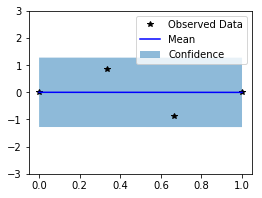

In [46]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [41]:
for name, data in model.named_parameters():
  print(name, data)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-13.6386], requires_grad=True)
mean_module.constant Parameter containing:
tensor([-4.7407e-05], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(2.2626, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-0.7638]], requires_grad=True)
